<a href="https://colab.research.google.com/github/AkashKK25/pneumonia-xray-detection/blob/main/notebooks/pneumonia_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pneumonia Detection from Chest X-Rays
#### Author: Akash Kumar Kondaparthi

## Setup and Imports

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from PIL import Image

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Check if GPU is available
print("GPU Available: ", tf.config.list_physical_devices('GPU'))

GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Downloading and preparing the dataset

In [ ]:
# Installing Kaggle API
!pip install kaggle

# Upload your Kaggle API credentials
from google.colab import files
print("Upload your kaggle.json file")
files.upload()  # Upload kaggle.json file

# Make a directory for Kaggle
!mkdir -p ~/.kaggle

# Copy the kaggle.json file
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download the dataset
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
!unzip -q chest-xray-pneumonia.zip

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other


## Exploring the dataset

Creating a better validation split...
Validation set expanded.
Training set: 1341 normal, 3875 pneumonia
Validation set: 276 normal, 783 pneumonia
Test set: 234 normal, 390 pneumonia


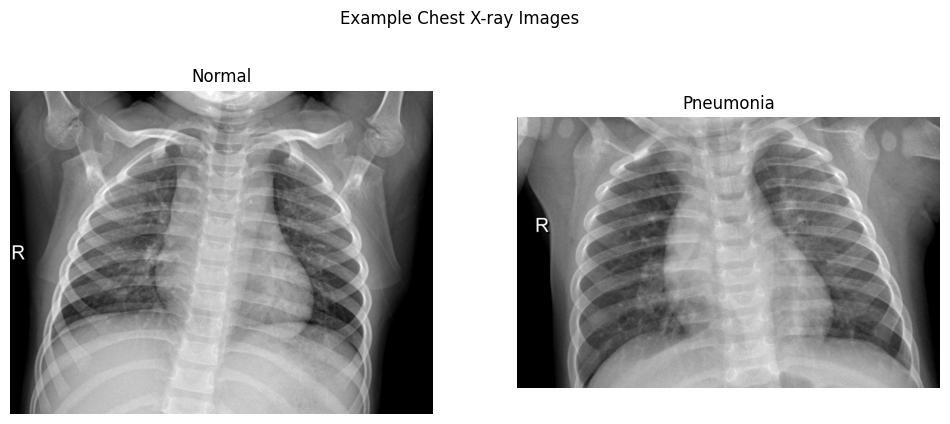

In [ ]:
train_dir = 'chest_xray/train'
val_dir = 'chest_xray/val'
test_dir = 'chest_xray/test'

# Check if the val directory exists - if not, create it from train
if not os.path.exists(val_dir) or len(os.listdir(os.path.join(val_dir, 'NORMAL'))) < 20:
    print("Creating a better validation split...")

    # Create val directory if it doesn't exist
    os.makedirs(os.path.join(val_dir, 'NORMAL'), exist_ok=True)
    os.makedirs(os.path.join(val_dir, 'PNEUMONIA'), exist_ok=True)

    # Move 20% of training data to validation
    import random
    import shutil

    for cls in ['NORMAL', 'PNEUMONIA']:
        src_dir = os.path.join(train_dir, cls)
        files = os.listdir(src_dir)
        num_val = int(len(files) * 0.2)  # 20% for validation
        val_files = random.sample(files, num_val)

        for file in val_files:
            src_path = os.path.join(src_dir, file)
            dst_path = os.path.join(val_dir, cls, file)
            shutil.copy(src_path, dst_path)  # Copy instead of move to preserve original

    print("Validation set expanded.")

# Count the number of images in each split
def count_images(directory):
    normal_count = len(os.listdir(os.path.join(directory, 'NORMAL')))
    pneumonia_count = len(os.listdir(os.path.join(directory, 'PNEUMONIA')))
    return normal_count, pneumonia_count

train_normal, train_pneumonia = count_images(train_dir)
val_normal, val_pneumonia = count_images(val_dir)
test_normal, test_pneumonia = count_images(test_dir)

print(f"Training set: {train_normal} normal, {train_pneumonia} pneumonia")
print(f"Validation set: {val_normal} normal, {val_pneumonia} pneumonia")
print(f"Test set: {test_normal} normal, {test_pneumonia} pneumonia")

# Visualize some example images
plt.figure(figsize=(12, 5))

# Normal example
normal_img_path = os.path.join(train_dir, 'NORMAL', os.listdir(os.path.join(train_dir, 'NORMAL'))[random.randint(0, train_normal-1)])
normal_img = Image.open(normal_img_path)
plt.subplot(1, 2, 1)
plt.imshow(normal_img, cmap='gray')
plt.title('Normal')
plt.axis('off')

# Pneumonia example
pneumonia_img_path = os.path.join(train_dir, 'PNEUMONIA', os.listdir(os.path.join(train_dir, 'PNEUMONIA'))[random.randint(0, train_pneumonia-1)])
pneumonia_img = Image.open(pneumonia_img_path)
plt.subplot(1, 2, 2)
plt.imshow(pneumonia_img, cmap='gray')
plt.title('Pneumonia')
plt.axis('off')

plt.suptitle('Example Chest X-ray Images')
plt.show()

## Data Preprocessing and Augmentation

In [ ]:
IMG_SIZE = 224  # MobileNetV2 input size

# Enhanced Data augmentation for training set
train_datagen = ImageDataGenerator(
    rescale=1./255,            # Hyperparameter tuning:
    rotation_range=20,         # Increased from 10
    width_shift_range=0.2,     # Increased from 0.1
    height_shift_range=0.2,    # Increased from 0.1
    shear_range=0.15,          # Increased from 0.1
    zoom_range=0.15,           # Increased from 0.1
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],  # Add brightness variation
    fill_mode='nearest'
)

# Only rescaling for validation and test sets
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Creating data generators
batch_size = 32

print("Booting up Train generator:")
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
)
print("\n")

print("Booting up Validation generator:")
validation_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)
print("\n")

print("Booting up Test generator:")
test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

Booting up Train generator:

Found 5216 images belonging to 2 classes.
Booting up Validation generator:

Found 1059 images belonging to 2 classes.
Booting up Test generator:

Found 624 images belonging to 2 classes.


In [ ]:
# Calculate class weights
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Get class distribution
train_normal, train_pneumonia = count_images(train_dir)
total_samples = train_normal + train_pneumonia
weight_for_0 = (1 / train_normal) * (total_samples / 2)
weight_for_1 = (1 / train_pneumonia) * (total_samples / 2)
class_weight = {0: weight_for_0, 1: weight_for_1}

print(f"Class weights: {class_weight}")

Class weights: {0: 1.9448173005219984, 1: 0.6730322580645162}


## Creating the Model using Transfer Learning

In [ ]:
# Loading the MobileNetV2 model with pre-trained ImageNet weights
base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

# Freezing the base model
base_model.trainable = False

# Adding custom layers on top of MobileNetV2
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = Dropout(0.5)(x)  # Increased from 0.2
predictions = Dense(1, activation='sigmoid')(x)

# Creating the model
model = Model(inputs=base_model.input, outputs=predictions)

# Compiling the model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Model summary
model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

## Model Training

In [ ]:
# Setting up callbacks for better training
checkpoint = ModelCheckpoint(
    'pneumonia_model_best.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

callbacks = [checkpoint, early_stopping, reduce_lr]

# Calculating steps per epoch and validation steps
steps_per_epoch = train_generator.samples // batch_size
validation_steps = validation_generator.samples // batch_size

# Training the model
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=25,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=callbacks
)

# Converting to TensorFlow Lite for deployment
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TF Lite model
with open('pneumonia_model_best.tflite', 'wb') as f:
    f.write(tflite_model)

print("Model converted to TensorFlow Lite format for deployment.")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 847ms/step - accuracy: 0.7543 - loss: 0.7261
Epoch 1: val_accuracy improved from -inf to 0.90720, saving model to pneumonia_model_best.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 178s 944ms/step - accuracy: 0.7547 - loss: 0.7253 - val_accuracy: 0.9072 - val_loss: 0.4687 - learning_rate: 1.0000e-04
Epoch 2/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 723ms/step - accuracy: 0.9008 - loss: 0.4352
Epoch 2: val_accuracy improved from 0.90720 to 0.91098, saving model to pneumonia_model_best.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 129s 790ms/step - accuracy: 0.9008 - loss: 0.4352 - val_accuracy: 0.9110 - val_loss: 0.4216 - learning_rate: 1.0000e-04
Epoch 3/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 702ms/step - accuracy: 0.9161 - loss: 0.3787
Epoch 3: val_accuracy did not improve from 0.91098
163/163 ━━━━━━━━━━━━━━━━━━━━ 125s 764ms/step - accuracy: 0.9161 - loss: 0.3787 - val_accuracy: 0.9015 - val_loss: 0.4125 - learning_rate: 1.0000e-04
Epoch 4/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 704ms/step - accuracy: 0.9308 - loss: 0.3391
Epoch 4: val_accuracy improved from 0.91098 to 0.93371, saving model to pneumonia_model_best.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 125s 770ms/step - accuracy: 0.9308 - loss: 0.3392 - val_accuracy: 0.9337 - val_loss: 0.3334 - learning_rate: 1.0000e-04
Epoch 5/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 705ms/step - accuracy: 0.9331 - loss: 0.3222
Epoch 5: val_accuracy did not improve from 0.93371
163/163 ━━━━━━━━━━━━━━━━━━━━ 142s 768ms/step - accuracy: 0.9331 - loss: 0.3222 - val_accuracy: 0.9062 - val_loss: 0.3754 - learning_rate: 1.0000e-04
Epoch 6/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 709ms/step - accuracy: 0.9386 - loss: 0.3023
Epoch 6: val_accuracy did not improve from 0.93371
163/163 ━━━━━━━━━━━━━━━━━━━━ 126s 772ms/step - accuracy: 0.9386 - loss: 0.3023 - val_accuracy: 0.9034 - val_loss: 0.3842 - learning_rate: 1.0000e-04
Epoch 7/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 703ms/step - accuracy: 0.9374 - loss: 0.2919
Epoch 7: val_accuracy did not improve from 0.93371
163/163 ━━━━━━━━━━━━━━━━━━━━ 125s 765ms/step - accuracy: 0.9374 - loss: 0.2919 - val_accuracy: 0.9242 - val_loss: 0.3167 - learning_rate

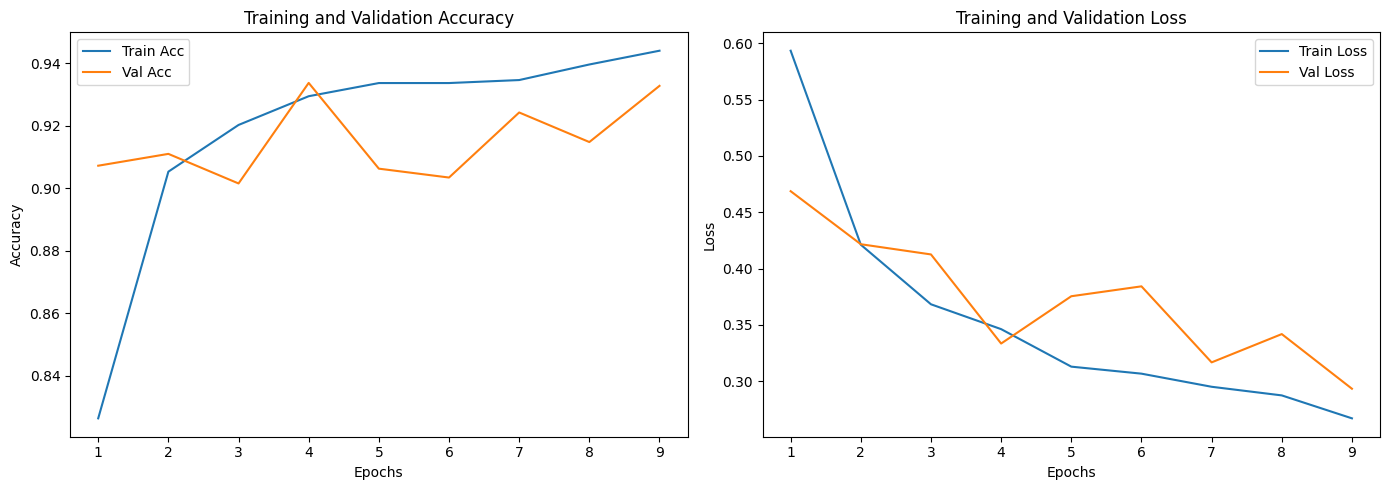

In [ ]:
total_epochs = len(history.history['accuracy'])
epochs_range = range(1, total_epochs + 1)

plt.figure(figsize=(14, 5))

# Plot training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(
    epochs_range[:len(history.history['accuracy'])],
    history.history['accuracy'],
    label='Train Acc'
)
plt.plot(
    epochs_range[:len(history.history['val_accuracy'])],
    history.history['val_accuracy'],
    label='Val Acc'
)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(
    epochs_range[:len(history.history['loss'])],
    history.history['loss'],
    label='Train Loss'
)
plt.plot(
    epochs_range[:len(history.history['val_loss'])],
    history.history['val_loss'],
    label='Val Loss'
)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

## Training the top layers, then fine-tuning a few convolutional layers

In [ ]:
# First train only the top layers
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=callbacks,
    class_weight=class_weight  # Add class weights
)

Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 698ms/step - accuracy: 0.9217 - loss: 0.3424
Epoch 1: val_accuracy did not improve from 0.93371
163/163 ━━━━━━━━━━━━━━━━━━━━ 131s 766ms/step - accuracy: 0.9217 - loss: 0.3424 - val_accuracy: 0.8674 - val_loss: 0.4718 - learning_rate: 1.0000e-04
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 701ms/step - accuracy: 0.9247 - loss: 0.3183
Epoch 2: val_accuracy did not improve from 0.93371
163/163 ━━━━━━━━━━━━━━━━━━━━ 138s 764ms/step - accuracy: 0.9247 - loss: 0.3183 - val_accuracy: 0.8646 - val_loss: 0.4729 - learning_rate: 1.0000e-04
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 695ms/step - accuracy: 0.9296 - loss: 0.3003
Epoch 3: val_accuracy did not improve from 0.93371
163/163 ━━━━━━━━━━━━━━━━━━━━ 123s 757ms/step - accuracy: 0.9296 - loss: 0.3003 - val_accuracy: 0.8485 - val_loss: 0.5005 - learning_rate: 1.0000e-04
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 702ms/step - accuracy: 0.9246 - loss: 0.3067
Epoch 4: val_accuracy did not improve from 0.933

In [ ]:
# Unfreezing just a few layers at a time
for layer in base_model.layers[-10:]:  # Unfreeze fewer layers (only last 10 instead of 20)
    layer.trainable = True
# Freezing the rest
for layer in base_model.layers[:-10]:
    layer.trainable = False

# Recompiling with a MUCH lower learning rate
model.compile(
    optimizer=Adam(learning_rate=0.000005),  # Even lower learning rate (5e-6 instead of 1e-5)
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Callbacks with more patience
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=8,              # Increased from 5
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,              # More gentle reduction (0.2 instead of 0.5)
    patience=5,              # Increased from 3
    min_lr=1e-7,
    verbose=1
)

callbacks = [checkpoint, early_stopping, reduce_lr]

# Fine-tuning with smaller batch size
batch_size = 16  # Reduced from 32
train_generator.batch_size = batch_size
validation_generator.batch_size = batch_size
steps_per_epoch = train_generator.samples // batch_size
validation_steps = validation_generator.samples // batch_size

# Training with fine-tuning
history_fine_tune = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=15,               # Increased from 10
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=callbacks,
    class_weight=class_weight  # Add class weights
)

Epoch 1/15
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step - accuracy: 0.8704 - loss: 0.3928
Epoch 1: val_accuracy did not improve from 0.93371
326/326 ━━━━━━━━━━━━━━━━━━━━ 141s 392ms/step - accuracy: 0.8705 - loss: 0.3927 - val_accuracy: 0.9148 - val_loss: 0.3503 - learning_rate: 5.0000e-06
Epoch 2/15
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step - accuracy: 0.9073 - loss: 0.3358
Epoch 2: val_accuracy did not improve from 0.93371
326/326 ━━━━━━━━━━━━━━━━━━━━ 118s 362ms/step - accuracy: 0.9073 - loss: 0.3358 - val_accuracy: 0.9233 - val_loss: 0.3211 - learning_rate: 5.0000e-06
Epoch 3/15
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step - accuracy: 0.9129 - loss: 0.3202
Epoch 3: val_accuracy did not improve from 0.93371
326/326 ━━━━━━━━━━━━━━━━━━━━ 143s 366ms/step - accuracy: 0.9129 - loss: 0.3202 - val_accuracy: 0.9337 - val_loss: 0.2981 - learning_rate: 5.0000e-06
Epoch 4/15
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step - accuracy: 0.9113 - loss: 0.3154
Epoch 4: val_accuracy did not improve from 0.933

## Evaluating the model

In [ ]:
# Combining the history objects
total_epochs = len(history.history['accuracy']) + len(history_fine_tune.history['accuracy'])
epochs_range = range(1, total_epochs + 1)

plt.figure(figsize=(14, 5))

# Plotting training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(
    epochs_range[:len(history.history['accuracy'])],
    history.history['accuracy'],
    label='Train Acc (Initial)'
)
plt.plot(
    epochs_range[:len(history.history['val_accuracy'])],
    history.history['val_accuracy'],
    label='Val Acc (Initial)'
)
plt.plot(
    epochs_range[len(history.history['accuracy']):],
    history_fine_tune.history['accuracy'],
    label='Train Acc (Fine-tune)'
)
plt.plot(
    epochs_range[len(history.history['val_accuracy']):],
    history_fine_tune.history['val_accuracy'],
    label='Val Acc (Fine-tune)'
)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting training & validation loss
plt.subplot(1, 2, 2)
plt.plot(
    epochs_range[:len(history.history['loss'])],
    history.history['loss'],
    label='Train Loss (Initial)'
)
plt.plot(
    epochs_range[:len(history.history['val_loss'])],
    history.history['val_loss'],
    label='Val Loss (Initial)'
)
plt.plot(
    epochs_range[len(history.history['loss']):],
    history_fine_tune.history['loss'],
    label='Train Loss (Fine-tune)'
)
plt.plot(
    epochs_range[len(history.history['val_loss']):],
    history_fine_tune.history['val_loss'],
    label='Val Loss (Fine-tune)'
)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

## Test set evaluation

In [ ]:
# Evaluating on test data
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# Getting predictions for test data
test_generator.reset()
y_pred = model.predict(test_generator)
y_pred_classes = (y_pred > 0.5).astype("int32")
y_true = test_generator.classes

# Calculating the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Pneumonia'],
            yticklabels=['Normal', 'Pneumonia'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Printing classification report
class_names = ['Normal', 'Pneumonia']
print(classification_report(y_true, y_pred_classes, target_names=class_names))

## Saving the model for deployment

In [ ]:
model.save('pneumonia_model_final.h5')
model.save('pneumonia_model_final.keras')

# Converting to TensorFlow Lite for deployment
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Saving the TF Lite model
with open('pneumonia_model_final.tflite', 'wb') as f:
    f.write(tflite_model)

print("Model converted to TensorFlow Lite format for deployment.")

## Visualizing model predictions on test images

In [ ]:
def display_predictions(model, test_dir, num_samples=6):
    # Get random images from test set
    normal_files = os.listdir(os.path.join(test_dir, 'NORMAL'))
    pneumonia_files = os.listdir(os.path.join(test_dir, 'PNEUMONIA'))

    # Randomly select images from each class
    normal_samples = np.random.choice(normal_files, min(num_samples//2, len(normal_files)), replace=False)
    pneumonia_samples = np.random.choice(pneumonia_files, min(num_samples//2, len(pneumonia_files)), replace=False)

    plt.figure(figsize=(15, 10))
    count = 1

    # Process normal images
    for sample in normal_samples:
        img_path = os.path.join(test_dir, 'NORMAL', sample)
        img = Image.open(img_path).convert('RGB')
        img = img.resize((IMG_SIZE, IMG_SIZE))
        img_array = np.array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)

        prediction = model.predict(img_array)[0][0]
        predicted_class = "Pneumonia" if prediction > 0.5 else "Normal"
        confidence = prediction if prediction > 0.5 else 1 - prediction

        plt.subplot(2, num_samples//2, count)
        plt.imshow(img)
        plt.title(f"True: Normal\nPred: {predicted_class}\nConfidence: {confidence*100:.2f}%")
        plt.axis('off')
        count += 1

    # Process pneumonia images
    for sample in pneumonia_samples:
        img_path = os.path.join(test_dir, 'PNEUMONIA', sample)
        img = Image.open(img_path).convert('RGB')
        img = img.resize((IMG_SIZE, IMG_SIZE))
        img_array = np.array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)

        prediction = model.predict(img_array)[0][0]
        predicted_class = "Pneumonia" if prediction > 0.5 else "Normal"
        confidence = prediction if prediction > 0.5 else 1 - prediction

        plt.subplot(2, num_samples//2, count)
        plt.imshow(img)
        plt.title(f"True: Pneumonia\nPred: {predicted_class}\nConfidence: {confidence*100:.2f}%")
        plt.axis('off')
        count += 1

    plt.tight_layout()
    plt.show()

# Displaying model predictions on sample test images
display_predictions(model, test_dir)

## Download the models

In [ ]:
from google.colab import files

files.download('pneumonia_model_best.h5')
files.download('pneumonia_model_best.tflite')

files.download('pneumonia_model_final.h5')
files.download('pneumonia_model_final.keras')
files.download('pneumonia_model_final.tflite')